### Making the data ready for training

In [1]:
# import the necessary packages
import os
import cv2
import numpy as np
from tqdm import tqdm       # for progress bar visualization

In [2]:
# defining some required variables
REBUILD_DATA = True # set to true to one once, then back to false unless you want to change something in your training data.

In [5]:
# defining the class for making the data ready for training
class DogsVSCats():
    IMG_SIZE = 75
    CATS = "./data/pet/Cat"
    DOGS = "./data/pet/Dog"
    TESTING = "./data/pet/Testing"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []

    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])
                        # do something like print(np.eye(2)[1]), just makes one_hot
                        #print(np.eye(2)[self.LABELS[label]])

                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1

                    except Exception as e:
                        pass
                        #print(label, f, str(e))

        np.random.shuffle(self.training_data)
        np.save("./data/pet/training_data.npy", self.training_data) # saving the training data in the form of numpy array
        print('Total Cat data found:',self.catcount)
        print('Total Dog data found:',self.dogcount)

In [6]:
# creating the training set and saving it locally in the form of numpy array
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

./data/pet/Cat


100%|██████████| 12501/12501 [01:56<00:00, 107.67it/s]


./data/pet/Dog


100%|██████████| 12501/12501 [01:52<00:00, 110.66it/s]
D:\Anaconda3\lib\site-packages\numpy\lib\npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Total Cat data found: 12476
Total Dog data found: 12470


##### Observations:
- Found 12501 cat images and 12501 dog images in the dataset but we found that 25 cat images and 31 dog images are corrupted so we are not able to read them using cv2.imread() function.

In [8]:
# loading the training data from the local storage into Tensor format required for PyTorch
training_data = np.load("./data/pet/training_data.npy", allow_pickle=True)
print(len(training_data))

24946


In [15]:
# import the necessary Pytorch packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [40]:
# importing visualization packages
import matplotlib.pyplot as plt
import time

In [10]:
# converting the training data into torch tensors
X = torch.Tensor([i[0] for i in training_data]).view(-1, 75, 75)
X = X/255.0     # normalizing the image data
y = torch.Tensor([i[1] for i in training_data])

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  


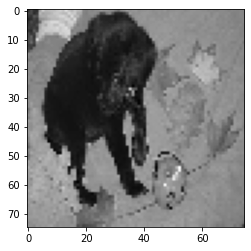

tensor([0., 1.])


In [12]:
# visualizing the data
plt.imshow(X[0], cmap="gray")
plt.show()
print(y[0])

### Creating the Convolutional Neural Network

In [13]:
# defining the class for creating the CNN
class Net(nn.Module):
    # initializing the layers of the CNN and FCN layers
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(75, 75).view(-1, 1, 75, 75)
        self._to_linear = None  # defining the variable for flattening the data before feeding it to the fully connected layer
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) # flattened data feeding to a fully connected layer
        self.fc2 = nn.Linear(512, 2) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).

    # defining the forward function for the CNN
    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2] # turns out to be (128*2*2) in our case
            # 128 -> conv3 output channels; `2*2` -> image dimension after max pooling
        return x

    # defining the forward function for the entire complete network
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view() is reshape ... this flattens X before
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # this is our output layer. No activation here.
        return F.softmax(x, dim=1) # dim=1 is the dimension to do softmax along (each image individually),
        # dim=0 is along the columns, dim=2 is along the rows, etc.

In [14]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


#### Assigning the optimizer and loss function

In [17]:
optimizer = optim.Adam(net.parameters(), lr=0.001) # defining the optimizer
loss_function = nn.MSELoss() # defining the loss function (Mean Squared Error)
# MSE is used for regression problems. It is the sum of squared distances between our target variable and predicted values.
# Good for calculating error for batches.

In [21]:
# Creating the training and validation data
VAL_PCT = 0.15  # let's reserve 15% of our data for validation

val_size = int(len(X)*VAL_PCT)
print("15 percent of the data will be: ", val_size)

15 percent of the data will be:  3741


In [20]:
# creating the training and validation data
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]
print("Train data size: ", len(train_X), "\nValidation data size: ", len(test_X))

Train data size:  21205 
Validation data size:  3741


In [22]:
# defining constants for the training process
BATCH_SIZE = 64
EPOCHS = 1

#### Training the CNN

In [33]:
def train(net):
    for epoch in range(EPOCHS):
        # from 0, to the len of train_X, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            #print(f"{i}:{i+BATCH_SIZE}")
            # batch creation
            batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 75, 75)
            batch_y = train_y[i:i+BATCH_SIZE]

            # sets gradients to 0 before loss calc. You will do this likely every step.
            net.zero_grad()

            # passing the batch thru the network
            outputs = net(batch_X) # calling the forward function with the batch data as input to the network
            loss = loss_function(outputs, batch_y)  # calc and grab the loss value by comparing the output with the batch_y
            loss.backward() # applies loss backwards thru the network's parameters (causing weight changes) (backpropagation)
            optimizer.step() # attempts to optimize weights to account for loss/gradients

        print(f"Epoch: {epoch}. Loss_train: {loss}")

train(net)

  0%|          | 0/332 [00:00<?, ?it/s]

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [24]:
# calculating the accuracy of the model for the validation data
def test(net):
    correct_predictions = 0.0
    total_val_data_size = 0.0

    # we don't need gradients for validation data as we are not going to do backpropagation for validation data
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            # real class is the actual class of the image (labeled manually)
            real_class = torch.argmax(test_y[i])

            # evaluating the image by passing it to the network
            net_out = net(test_X[i].view(-1, 1, 75, 75))[0]  # returns a list,
            # net_out is the output of the network for the test data

            predicted_class = torch.argmax(net_out)  # predicted class is the class with maximum probability
            if predicted_class == real_class:
                correct_predictions += 1
            total_val_data_size += 1

    print("Validation Accuracy: ", round(correct_predictions/total_val_data_size, 3))

test(net)

100%|██████████| 3741/3741 [00:09<00:00, 400.87it/s]

Validation Accuracy:  0.598


- Received a pretty decent accuracy for training the model for just 1 epoch.

In [25]:
# saving the model
torch.save(net, "./models/pet_CPU_e0_CNN_model.pt")

In [ ]:
# loading the model
# net = torch.load("./models/pet_CPU_e0_CNN_model.pt")

### Will be using the GPU for training the model

In [31]:
# checking if GPU is available
# torch.cuda.is_available()
if torch.cuda.is_available():
    print("Running on the GPU...\nTotal GPU's available: ", torch.cuda.device_count())
    print("Device Name: ", torch.cuda.get_device_name(0))
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU...
Total GPU's available:  1
Device Name:  NVIDIA GeForce GTX 1060


In [32]:
# moving the model to the GPU
net.to(device)  # OR net = Net().to(device)  # moving to GPU while initializing the model only

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [35]:
# constants
BATCH_SIZE = 128
EPOCHS = 5

In [36]:
# training the model on the GPU
def train(net):
    optimizer = optim.Adam(net.parameters(), lr=0.001) # defining the optimizer
    loss_function = nn.MSELoss()

    for epoch in range(EPOCHS):
        # from 0, to the len of train_X, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            #print(f"{i}:{i+BATCH_SIZE}")
            # batch creation
            batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 75, 75)
            batch_y = train_y[i:i+BATCH_SIZE]

            # moving the batch to the GPU
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # sets gradients to 0 before loss calc. You will do this likely every step.
            net.zero_grad()

            # passing the batch thru the network
            outputs = net(batch_X) # calling the forward function with the batch data as input to the network
            loss = loss_function(outputs, batch_y)  # calc and grab the loss value by comparing the output with the batch_y
            loss.backward() # applies loss backwards thru the network's parameters (causing weight changes) (backpropagation)
            optimizer.step() # attempts to optimize weights to account for loss/gradients

        print(f"Epoch: {epoch}. Loss_train: {loss}")

train(net)


100%|██████████| 166/166 [00:24<00:00,  6.79it/s]

  1%|          | 2/166 [00:00<00:12, 13.41it/s]

Epoch: 0. Loss_train: 0.23855216801166534



100%|██████████| 166/166 [00:24<00:00,  6.87it/s]

  1%|          | 2/166 [00:00<00:12, 13.49it/s]

Epoch: 1. Loss_train: 0.2140742689371109



100%|██████████| 166/166 [00:24<00:00,  6.89it/s]

  1%|          | 2/166 [00:00<00:12, 13.44it/s]

Epoch: 2. Loss_train: 0.17215240001678467



100%|██████████| 166/166 [00:24<00:00,  6.86it/s]

  1%|          | 2/166 [00:00<00:12, 13.53it/s]

Epoch: 3. Loss_train: 0.14800766110420227



100%|██████████| 166/166 [00:23<00:00,  6.93it/s]


Epoch: 4. Loss_train: 0.13555476069450378


In [38]:
# testing the model on the GPU
def test(net):
    correct_predictions = 0.0
    total_val_data_size = 0.0

    # we don't need gradients for validation data as we are not going to do backpropagation for validation data
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            # real class is the actual class of the image (labeled manually)
            real_class = torch.argmax(test_y[i]).to(device)

            # evaluating the image by passing it to the network
            net_out = net(test_X[i].view(-1, 1, 75, 75).to(device))[0]  # returns a list,
            # net_out is the output of the network for the test data

            predicted_class = torch.argmax(net_out)  # predicted class is the class with maximum probability
            if predicted_class == real_class:
                correct_predictions += 1
            total_val_data_size += 1

    print("Validation Accuracy: ", round(correct_predictions/total_val_data_size, 3))

test(net)


100%|██████████| 3741/3741 [00:07<00:00, 481.67it/s]

Validation Accuracy:  0.79


#### Model Analysis
---
- Calculating the Accuracies and Losses for the training and validation data for the model.
- Visualizing them in the form of graphs.

In [39]:
# Single forward pass function for both training and validation data
def fwd_pass(X, y, train=False):
    if train:
        net.zero_grad()
    outputs = net(X)
    matches  = [torch.argmax(i)==torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)

    if train:
        loss.backward()
        optimizer.step()

    return acc, loss

In [43]:
def validation_test(size=32):
    random_start = np.random.randint(len(test_X)-size)
    X, y = test_X[random_start:random_start+size], test_y[random_start:random_start+size]
    val_acc, val_loss = fwd_pass(X.view(-1, 1, 75, 75).to(device), y.to(device))
    return val_acc, val_loss

val_acc, val_loss = validation_test(size=100)
print("accuracy: ", val_acc, "\nLoss:", val_loss)

accuracy:  0.87 
Loss: tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)


In [44]:
# constants declaration
MODEL_NAME = f"model-{int(time.time())}"  # gives a dynamic model name, to just help with things getting messy over time.
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [47]:
# training the model
def train(net):
    BATCH_SIZE = 128
    EPOCHS = 3

    with open("./logs/convnet_model.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 75, 75)
                batch_y = train_y[i:i+BATCH_SIZE]

                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                acc, loss = fwd_pass(batch_X, batch_y, train=True)

                #print(f"Acc: {round(float(acc),2)}  Loss: {round(float(loss),4)}")
                #f.write(f"{MODEL_NAME},{round(time.time(),3)},train,{round(float(acc),2)},{round(float(loss),4)}\n")
                # just to show the above working, and then get out:
                if i % 20 == 0:
                    val_acc, val_loss = validation_test(size=100)
                    f.write(f"{MODEL_NAME},{round(time.time(),3)},"
                            f"{round(float(acc),2)},{round(float(loss), 4)},"
                            f"{round(float(val_acc),2)},{round(float(val_loss),4)}\n")
train(net)


100%|██████████| 166/166 [00:29<00:00,  5.67it/s]

100%|██████████| 166/166 [00:28<00:00,  5.92it/s]

100%|██████████| 166/166 [00:27<00:00,  6.03it/s]


In [52]:
from matplotlib import style

style.use("ggplot")

model_name = MODEL_NAME
# grab whichever model name you want here.
# We could also just reference the MODEL_NAME if you're in a notebook still.


def create_acc_loss_graph(model_name):
    contents = open("./logs/convnet_model.log", "r").read().split("\n")

    times = []
    accuracies = []
    losses = []

    val_accs = []
    val_losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss = c.split(",")

            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))

            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))


    fig = plt.figure(figsize=(20, 15))

    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)


    ax1.plot(times, accuracies, label="acc")
    ax1.plot(times, val_accs, label="val_acc")
    ax1.legend(loc=2)
    ax2.plot(times,losses, label="loss")
    ax2.plot(times,val_losses, label="val_loss")
    ax2.legend(loc=2)
    plt.show()

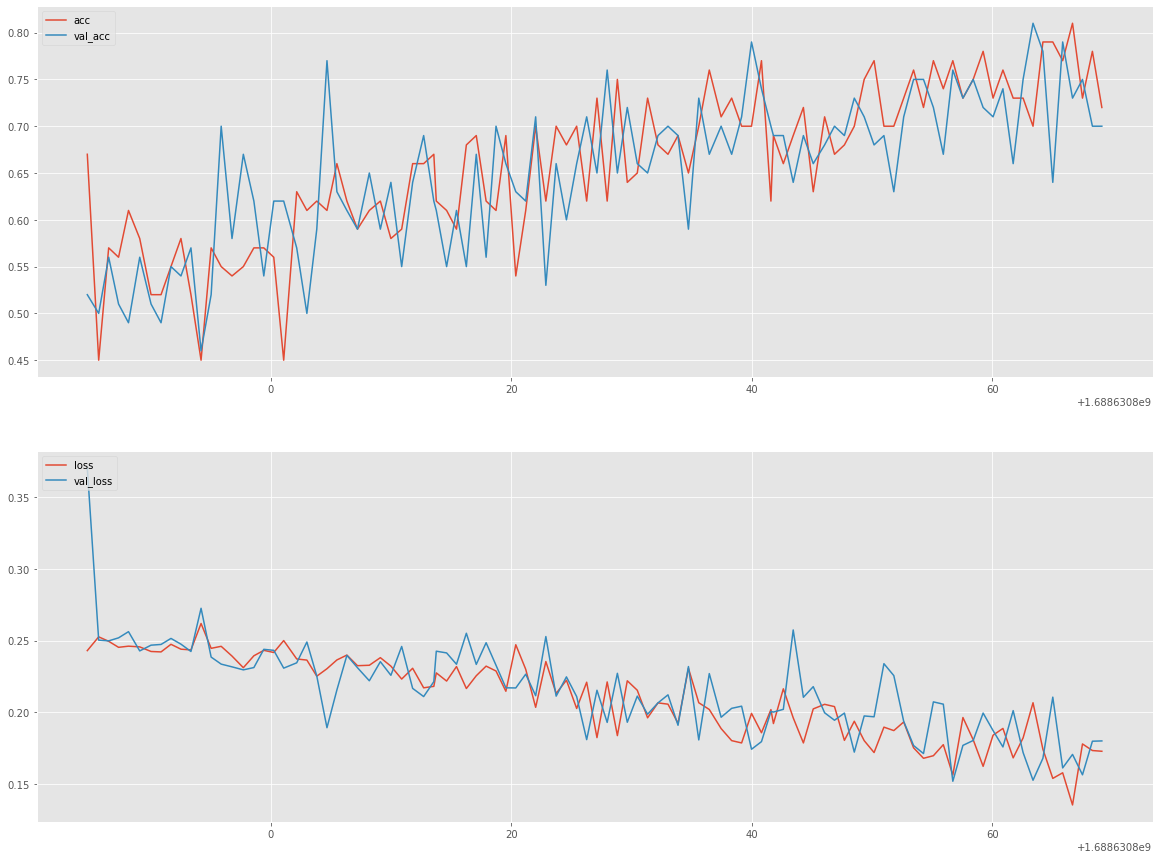

In [53]:
create_acc_loss_graph(model_name)